# Project

Modèles à tester : GAM, cart, random forest, XGBoost



### How it works:
The aFRR (automatic Frequency Restoration Reserve) is a system service market in several European countries designed to help maintain grid balance. Participants in the market submit offers to either increase or decrease electricity production based on real-time demand, providing flexibility to the electricity system. 

1. **Auction Setup**: 
   - The aFRR auctions occur daily around 8 a.m., for electricity delivery the next day.
   - Each day features 12 product types, which represent the need to either increase or decrease production within four-hour slots (e.g., POS_00_04 for increased production from 00:00–04:00).
   - These products are treated as independent, each having a specific demand published in advance.

2. **Pricing Mechanism**:
   - Market participants submit bid curves (volume/price), which are sorted by price.
   - The equilibrium price for each product is set by the highest-priced offer that meets the required demand.

### The Data

We've collected some datasets that contain data about the aFFR market for Germany and Austria over a period of 8 months.
   - **Demand**: Data on the demand for each product for each day over a period of 8 months.
   - **Auction results stats**: File with statistics of the accepted bids (equilibrium price, volume,...)
   - **Accepted Bids**: Files showing all accepted bids, with breakdowns for Germany and Austria, for each product daily => not very useful in practice

### The project

Given all these features, predict the equilibrium price for a given product (or for all products if possible). The equilibrium prices are listed in the column "AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]" and "GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]" in the result overview dataset.

# Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

file_path_demand = 'donneesAFRR/LIST_OF_TENDERS_CAPACITY_MARKET_aFRR_2024-01-01_2024-08-31.xlsx'
df_demand = pd.read_excel(file_path_demand, sheet_name=None)["001"]
df_demand = df_demand.drop(columns=['APG_AREA_CORE_PORTION_[MW]'])


file_path_results = "donneesAFRR/RESULT_OVERVIEW_CAPACITY_MARKET_aFRR_2024-01-01_2024-08-31.xlsx"
# Read all sheets into a dictionary of DataFrames
df_results = pd.read_excel(file_path_results, sheet_name=None)["001"]

In [23]:
pd.set_option('display.max_columns', None)
df_demand = df_demand.apply(lambda col: col.astype('string') if col.dtype == 'object' else col)

df_demand.head(20)


,DATE_FROM,DATE_TO,GATE_OPEN_TIME,GATE_CLOSURE_TIME,ALLOCATION_DEADLINE,TENDER_TYPE,ROUND,TYPE_OF_RESERVES,PRODUCT,TOTAL_DEMAND_[MW],GERMANY_BLOCK_DEMAND_[MW],GERMANY_BLOCK_EXPORT_LIMIT_[MW],GERMANY_BLOCK_CORE_PORTION_[MW],50HERTZ_AREA_CORE_PORTION_[MW],AMPRION_AREA_CORE_PORTION_[MW],TRANSNETBW_AREA_CORE_PORTION_[MW],TENNET_AREA_CORE_PORTION_[MW],AUSTRIA_BLOCK_DEMAND_[MW],AUSTRIA_BLOCK_EXPORT_LIMIT_[MW],AUSTRIA_BLOCK_CORE_PORTION_[MW]
0,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,NEG_00_04,2092,1892,80,0,0,0,0,0,200,80,100
1,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,NEG_04_08,2038,1838,80,0,0,0,0,0,200,80,100
2,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,NEG_08_12,2244,2044,80,0,0,0,0,0,200,80,100
3,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,NEG_12_16,2189,1989,80,0,0,0,0,0,200,80,100
4,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,NEG_16_20,2140,1940,80,0,0,0,0,0,200,80,100
5,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,NEG_20_24,2183,1983,80,0,0,0,0,0,200,80,100
6,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,POS_00_04,2013,1813,80,0,0,0,0,0,200,80,100
7,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,POS_04_08,2060,1860,80,0,0,0,0,0,200,80,100
8,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,POS_08_12,1991,1791,80,0,0,0,0,0,200,80,100
9,2024-01-01,2024-01-01,2023-12-25 10:00:00,2023-12-31 09:00:00,2023-12-31 09:30:00,DAILY,1,aFRR,POS_12_16,2041,1841,80,0,0,0,0,0,200,80,100


In [24]:
df_results.head()

,DATE_FROM,DATE_TO,TYPE_OF_RESERVES,PRODUCT,TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h],TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]
0,2024-01-01,2024-01-01,aFRR,POS_00_04,2.20,4.63,5.25,4.01,4.72,5.25,21,2.20,3.78,5.01,-21,3637
1,2024-01-01,2024-01-01,aFRR,POS_04_08,2.28,4.63,5.01,3.65,4.67,5.01,44,2.28,4.06,5.00,-44,3655
2,2024-01-01,2024-01-01,aFRR,POS_08_12,3.24,6.24,6.66,5.15,6.33,6.66,-19,3.24,5.57,6.63,19,3732
3,2024-01-01,2024-01-01,aFRR,POS_12_16,2.04,4.06,4.41,3.10,4.12,4.41,8,2.04,3.56,4.40,-8,3878
4,2024-01-01,2024-01-01,aFRR,POS_16_20,5.73,11.13,11.92,10.03,11.36,11.92,-48,5.73,9.40,11.82,48,4184


In [25]:
print(df_demand.dtypes)


DATE_FROM                            datetime64[ns]
DATE_TO                              datetime64[ns]
GATE_OPEN_TIME                       datetime64[ns]
GATE_CLOSURE_TIME                    datetime64[ns]
ALLOCATION_DEADLINE                  datetime64[ns]
TENDER_TYPE                          string[python]
ROUND                                         int64
TYPE_OF_RESERVES                     string[python]
PRODUCT                              string[python]
TOTAL_DEMAND_[MW]                             int64
GERMANY_BLOCK_DEMAND_[MW]                     int64
GERMANY_BLOCK_EXPORT_LIMIT_[MW]               int64
GERMANY_BLOCK_CORE_PORTION_[MW]               int64
50HERTZ_AREA_CORE_PORTION_[MW]                int64
AMPRION_AREA_CORE_PORTION_[MW]                int64
TRANSNETBW_AREA_CORE_PORTION_[MW]             int64
TENNET_AREA_CORE_PORTION_[MW]                 int64
AUSTRIA_BLOCK_DEMAND_[MW]                     int64
AUSTRIA_BLOCK_EXPORT_LIMIT_[MW]               int64
AUSTRIA_BLOC

In [26]:
print(df_demand.describe())

                           DATE_FROM                        DATE_TO  \
count                           2928                           2928   
mean   2024-05-01 12:00:00.000000256  2024-05-01 12:00:00.000000256   
min              2024-01-01 00:00:00            2024-01-01 00:00:00   
25%              2024-03-01 18:00:00            2024-03-01 18:00:00   
50%              2024-05-01 12:00:00            2024-05-01 12:00:00   
75%              2024-07-01 06:00:00            2024-07-01 06:00:00   
max              2024-08-31 00:00:00            2024-08-31 00:00:00   
std                              NaN                            NaN   

            GATE_OPEN_TIME    GATE_CLOSURE_TIME  \
count                 2928                 2928   
mean   2024-04-24 22:00:00  2024-04-30 21:00:00   
min    2023-12-25 10:00:00  2023-12-31 09:00:00   
25%    2024-02-24 04:00:00  2024-03-01 03:00:00   
50%    2024-04-24 22:00:00  2024-04-30 21:00:00   
75%    2024-06-24 16:00:00  2024-06-30 15:00:00   
max

In [27]:
df_results = df_results.apply(lambda col: col.astype('string') if col.dtype == 'object' else col)

df_results.head()

,DATE_FROM,DATE_TO,TYPE_OF_RESERVES,PRODUCT,TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h],TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]
0,2024-01-01,2024-01-01,aFRR,POS_00_04,2.20,4.63,5.25,4.01,4.72,5.25,21,2.20,3.78,5.01,-21,3637
1,2024-01-01,2024-01-01,aFRR,POS_04_08,2.28,4.63,5.01,3.65,4.67,5.01,44,2.28,4.06,5.00,-44,3655
2,2024-01-01,2024-01-01,aFRR,POS_08_12,3.24,6.24,6.66,5.15,6.33,6.66,-19,3.24,5.57,6.63,19,3732
3,2024-01-01,2024-01-01,aFRR,POS_12_16,2.04,4.06,4.41,3.10,4.12,4.41,8,2.04,3.56,4.40,-8,3878
4,2024-01-01,2024-01-01,aFRR,POS_16_20,5.73,11.13,11.92,10.03,11.36,11.92,-48,5.73,9.40,11.82,48,4184


In [28]:
serie_1 = df_results[(df_results["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"]>0) & (df_results["PRODUCT"] == "POS_00_04")]["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"]
serie_2 = df_results[(df_results["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"]>0) & (df_results["PRODUCT"] == "POS_00_04")]["GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]"]
print(serie_1.mean())
print(serie_2.mean())


36.97727272727273
5.055681818181817


In [30]:
serie_1 = df_results[(df_results["AUSTRIA_IMPORT(-)_EXPORT(+)_[MW]"]>0) & (df_results["PRODUCT"] == "POS_00_04")]["AUSTRIA_IMPORT(-)_EXPORT(+)_[MW]"]
serie_2 = df_results[(df_results["AUSTRIA_IMPORT(-)_EXPORT(+)_[MW]"]>0) & (df_results["PRODUCT"] == "POS_00_04")]["AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]"]
print(serie_1.mean())
print(serie_2.mean())

59.898477157360404
4.2954314720812174


In [29]:
print(df_results.dtypes)

DATE_FROM                                       datetime64[ns]
DATE_TO                                         datetime64[ns]
TYPE_OF_RESERVES                                string[python]
PRODUCT                                         string[python]
TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h]                  float64
TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]              float64
TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]             float64
GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h]                float64
GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]            float64
GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]           float64
GERMANY_IMPORT(-)_EXPORT(+)_[MW]                         int64
AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h]                float64
AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]            float64
AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]           float64
AUSTRIA_IMPORT(-)_EXPORT(+)_[MW]                         int64
GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]                   

In [9]:
df_results["GERMANY_IMPORT(-)_EXPORT(+)_[MW]", "TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h]", "TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]", "TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]

KeyError: ('GERMANY_IMPORT(-)_EXPORT(+)_[MW]', 'TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h]', 'TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h]', 'TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]')

# Cleaning

In [10]:
print(df_results.isna().any().any(), df_demand.isna().any().any())
# => no NaN values

False False


In [11]:
result = df_results["PRODUCT"][0]

df_price = df_results.loc[df_results['PRODUCT'] == result, ["AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]].squeeze()

df_price

0       5.01
12      5.13
24      4.80
36      4.60
48      4.86
        ... 
2868    7.25
2880    6.02
2892    5.43
2904    5.28
2916    4.96
Name: AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h], Length: 244, dtype: float64

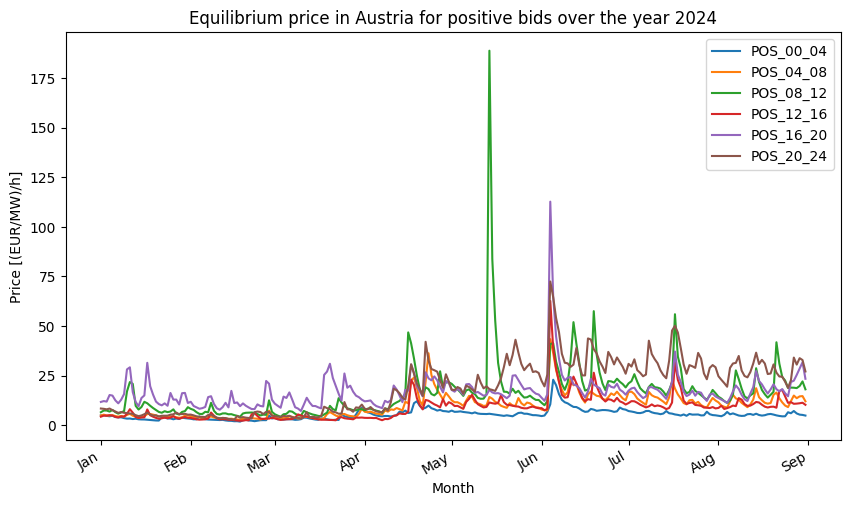

In [12]:
import matplotlib.dates as mdates
plt.figure(figsize=(10, 6))

for i in range(6):
    result = df_results["PRODUCT"].unique()[i % len(df_results["PRODUCT"].unique())]
    df_price = df_results.loc[df_results['PRODUCT'] == result, ["DATE_FROM", "AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]
    plt.plot(df_price["DATE_FROM"], df_price["AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"], label= result)

# Format the x-axis to show months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # '%b' for abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

plt.title("Equilibrium price in Austria for positive bids over the year 2024")
plt.xlabel('Month')
plt.ylabel('Price [(EUR/MW)/h]')
plt.legend()
plt.show()

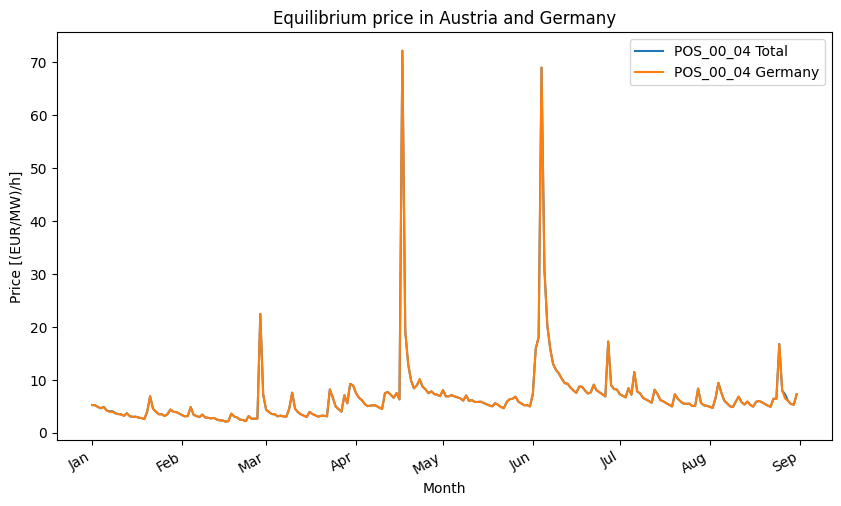

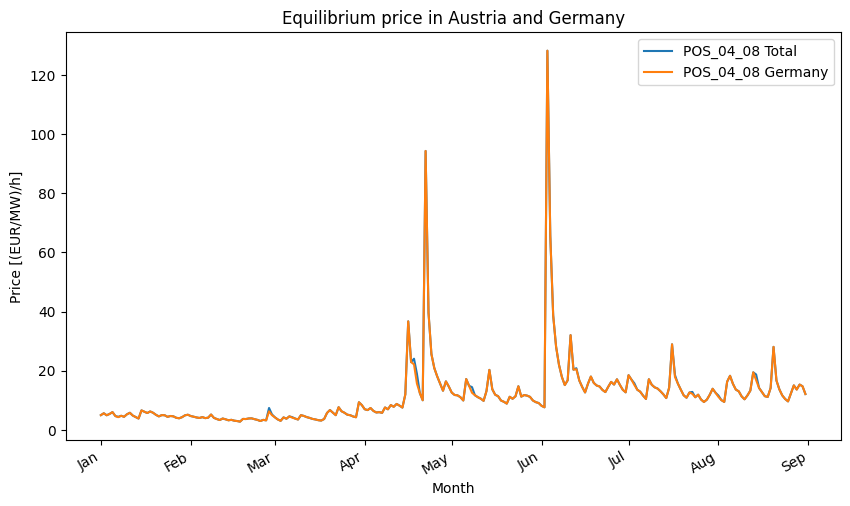

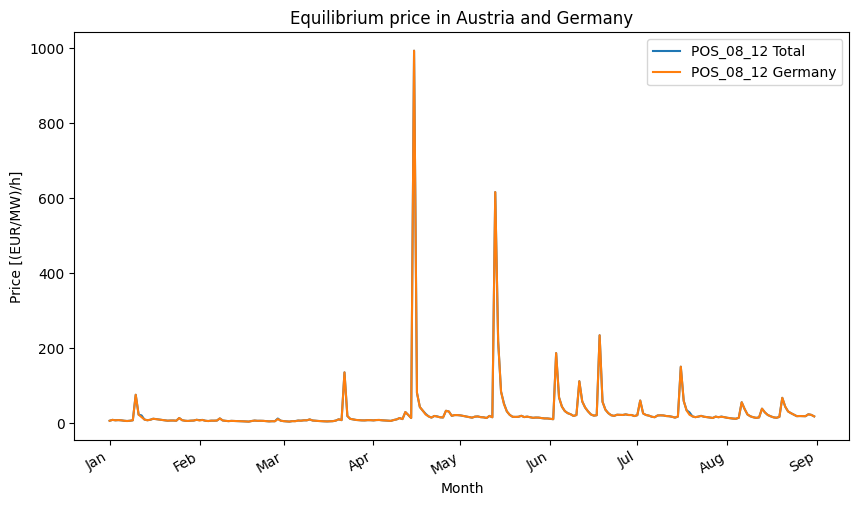

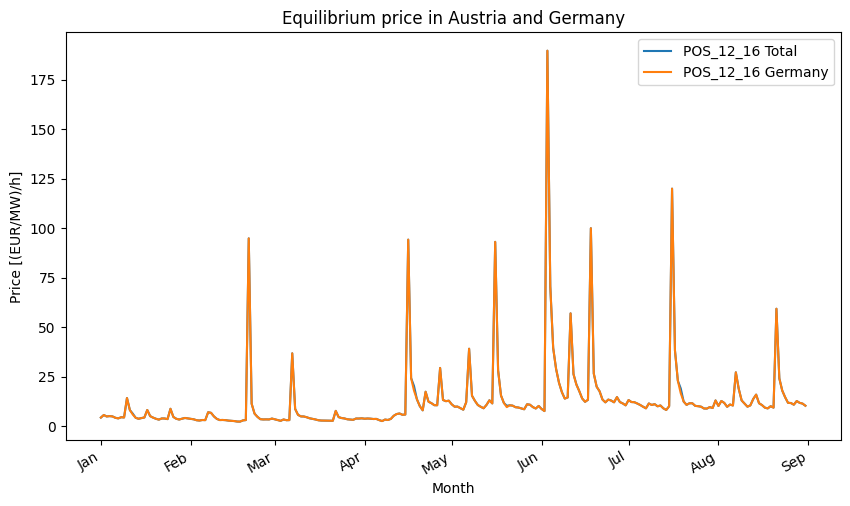

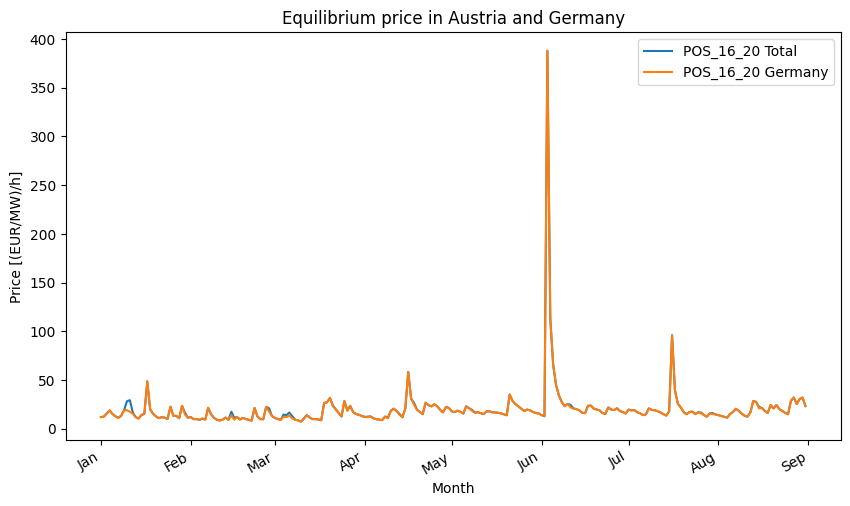

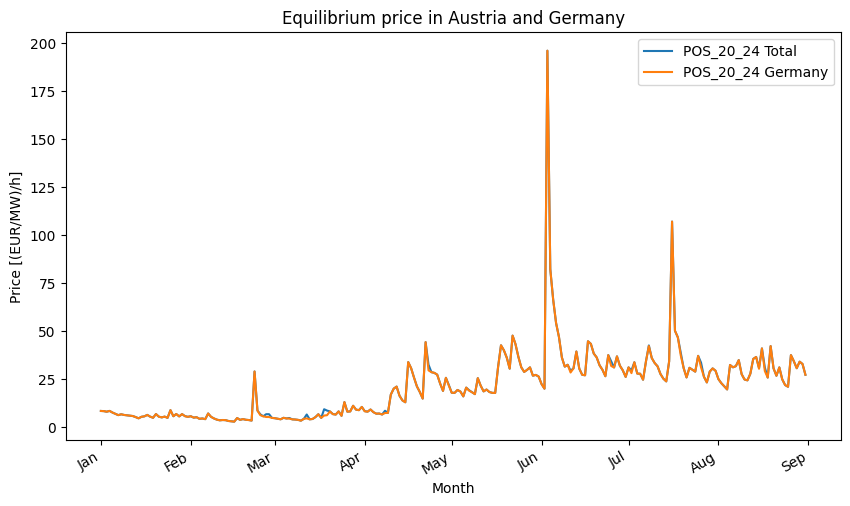

In [13]:
import matplotlib.dates as mdates
for i in range(6):
    plt.figure(figsize=(10, 6))

    result = df_results["PRODUCT"][i]
    df_price_austria = df_results.loc[df_results['PRODUCT'] == result, ["DATE_FROM", "AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]
    df_price_germany = df_results.loc[df_results['PRODUCT'] == result, ["DATE_FROM", "GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]
    df_price_total = df_results.loc[df_results['PRODUCT'] == result, ["DATE_FROM", "TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]
    
    plt.plot(df_price_total["DATE_FROM"], df_price_total["TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"], label= result + " Total")
    plt.plot(df_price_germany["DATE_FROM"], df_price_germany["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"], label= result + " Germany")
    # plt.plot(df_price_austria["DATE_FROM"], df_price_austria["AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"], label= result + " Austria")

    # Format the x-axis to show months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # '%b' for abbreviated month names
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    plt.title("Equilibrium price in Austria and Germany")
    plt.xlabel('Month')
    plt.ylabel('Price [(EUR/MW)/h]')
    plt.legend()
    plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

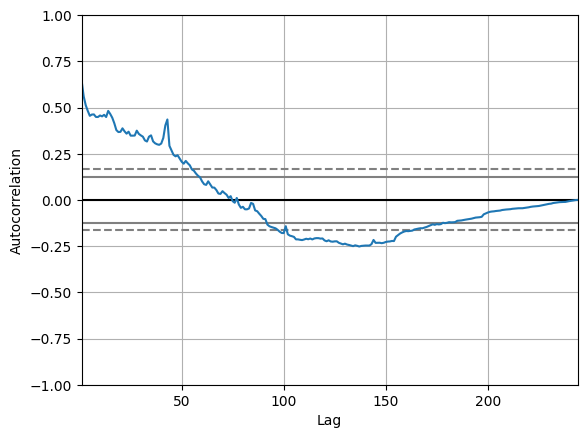

In [14]:
w

autocorrelation_plot(df_price_germany["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"])

In [15]:
from statsmodels.tsa.arima.model import ARIMA

df_price_germany.set_index('DATE_FROM', inplace=True)
pd.index = pd.to_datetime(df_price_germany.index)

df_price_germany = df_price_germany.asfreq('D')


In [16]:
df_price_germany

,GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]
DATE_FROM,
2024-01-01,8.51
2024-01-02,8.43
2024-01-03,8.12
2024-01-04,8.54
2024-01-05,7.68
...,...
2024-08-27,34.45
2024-08-28,30.78
2024-08-29,34.20


/usr/local/Anaconda3-2022.10/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/Anaconda3-2022.10/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


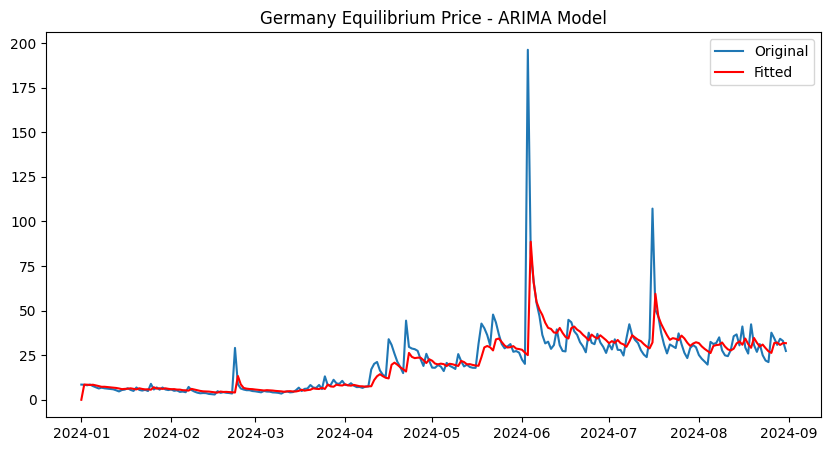

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Load your time series data
series = df_price_germany['GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]']

# Step 1: Visualize the data
# plt.plot(series)
# plt.show()

# Step 2: Determine differencing order d
result = adfuller(series)
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

# If p-value > 0.05, the series is not stationary and needs differencing
d = 0
original_series = series.copy()  # Save the original series for plotting
while result[1] > 0.05:
    series = series.diff().dropna()
    result = adfuller(series)
    d += 1

# print(f'Differencing order d: {d}')

# Step 3: Determine AR order p using PACF
# plot_pacf(series, lags=20)
# plt.show()

# Step 4: Determine MA order q using ACF
# plot_acf(series, lags=20)
# plt.show()

# Step 5: Model selection
# Fit ARIMA model
p = 2  # Example value, choose based on PACF plot
q = 2  # Example value, choose based on ACF plot
model = ARIMA(original_series, order=(p, d, q))
model_fit = model.fit()

# print(model_fit.summary())

# Align fitted values with the original series
fitted_values = model_fit.fittedvalues
if d > 0:
    fitted_values = np.concatenate([np.repeat(np.nan, d), fitted_values])

plt.figure(figsize=(10, 5))
plt.plot(df_price_germany["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"], label='Original')
plt.plot(df_price_germany.index,fitted_values[1:], color='red', label='Fitted')
plt.title('Germany Equilibrium Price - ARIMA Model')
plt.legend()
plt.show()


In [18]:
len(fitted_values)

245

In [19]:
print(df_price_germany["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"])

DATE_FROM
2024-01-01     8.51
2024-01-02     8.43
2024-01-03     8.12
2024-01-04     8.54
2024-01-05     7.68
              ...  
2024-08-27    34.45
2024-08-28    30.78
2024-08-29    34.20
2024-08-30    32.98
2024-08-31    27.36
Freq: D, Name: GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h], Length: 244, dtype: float64


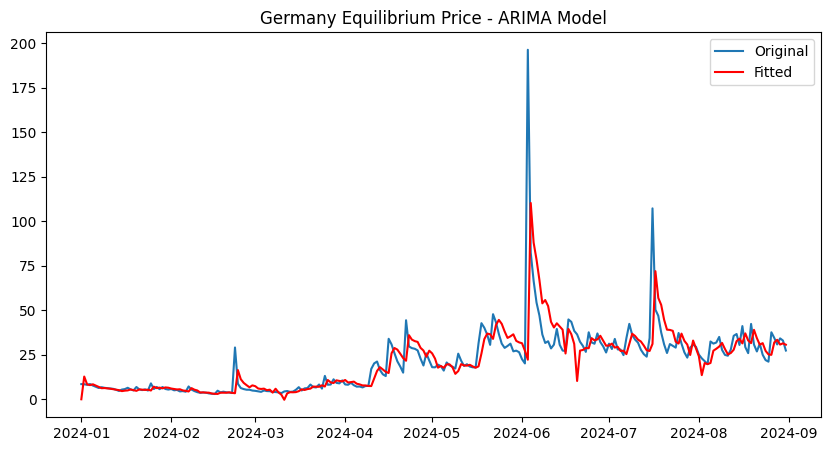

In [20]:

model=ARIMA(df_price_germany, order  = (15, 2, 0))
model_fit = model.fit()

# # Print summary of the model
# print("Germany ARIMA Model Summary:")
# print(model_fit.summary())

# Plot the fitted values
plt.figure(figsize=(10, 5))
plt.plot(df_price_germany["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"], label='Original')
plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
plt.title('Germany Equilibrium Price - ARIMA Model')
plt.legend()
plt.show()

# Test preprocess.py

In [21]:
%load_ext autoreload
%autoreload 2

In [12]:
from preprocess import data
